## Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

Welcome to Milestone Project 3, BitPredict 💰📈!

🔑 **Note**: ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![typesOfTimeSeriesProblems.png](Images/typesOfTimeSeriesProblems.png)

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

## What we're going to cover

### Are you ready?

We've got a lot to go through.

* Get time series data (the historical price of Bitcoin)
    * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem)


## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

#### Why these dates?

Because **01 October 2013** is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and **18 May 2021** is when this notebook was created.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict on later dates of Bitcoin, you'll just have to adjust the data source.

📖 **Resource**: To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV".

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).

In [1]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-12-16 10:43:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-12-16 10:44:00 (14.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas

Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in `CSV (comma separated values)` format (a very common data format for time series), we'll use the pandas `read_csv()` function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column (`"Date"`).

In [3]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


Looking good! Let's get some more info.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

![bitpriceintro.png](Images/bitpriceintro.png)

🔑 Note: The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see Forecasting: [Principles and Practice Chapter 2.3.](https://otexts.com/fpp3/tspatterns.html)

![typesOfTimeSeries.png](Images/typesOfTimeSeries.png)

*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [6]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

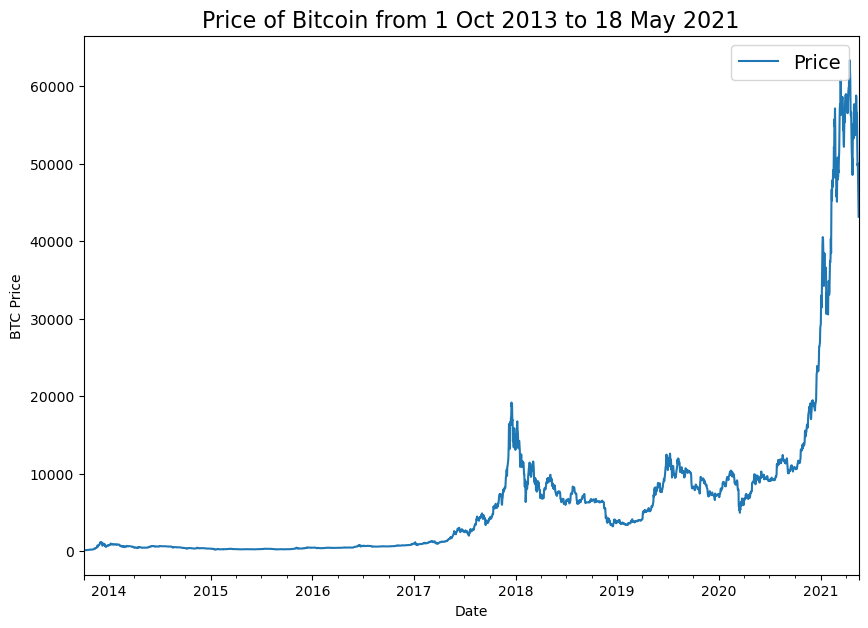

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

## Importing time series data with Python's CSV module

If your time series data comes in `CSV` form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's `datetime`.

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

📖 **Resource**: For a great guide on using Python's `csv` module, check out [Real Python's tutorial on Reading and Writing `CSV` files in Python](https://realpython.com/python-csv/).

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[2])) # get the closing price as float
        
# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Beautiful! Now, let's see how things look.

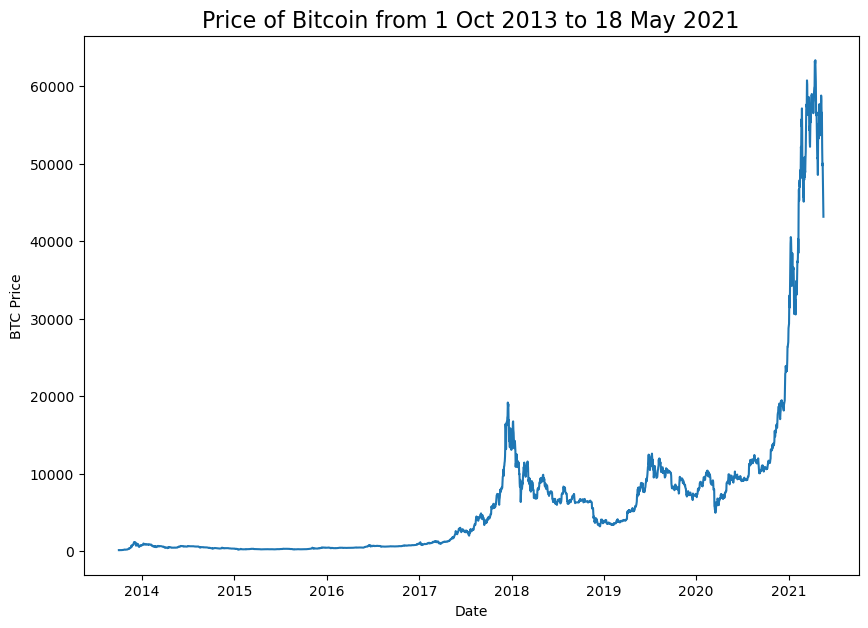

In [9]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

Ho ho! Would you look at that! Just like the pandas plot. And because we formatted the timesteps to be datetime objects, matplotlib displays a fantastic looking date axis.

## Format Data Part 1: Creatining train and test sets for time series data

Alrighty. What's next?

If you guessed preparing our data for a model, you'd be right.

What's the most important first step for preparing any machine learning dataset?

Scaling?

No...

Removing outliers?

No...

How about creating train and test splits?

Yes!

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding `train_test_split()` but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what kind of data we have.

In time series problems, you'll either have `univariate` or `multivariate` data.

Can you guess what our data is?

* `Univariate time series data` deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* `Multivariate time series data` deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![univariateAndMultivariate.png](Images/univariateAndMultivariate.png)

## Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables).

How about we first see the wrong way for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.